This is a notebook for experimenting with the PKU cephalogram dataset. Goals:

- Plotting the landmarks over the radiographs
- Try to extract standardized measurements (Angles, Distances), for example overbite

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [2]:
def load_image(image_path):
    """
    Loads a BMP cephalometric radiograph.
    Returns: grayscale image as numpy array.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    return img

def load_landmarks(txt_path):
    """
    Loads landmarks from a txt file.
    Each line should contain two numbers (x, y).
    Returns: list of (x, y) tuples as ints.
    """
    landmarks = []
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().replace(',', ' ').split()
            if len(parts) >= 2:
                x, y = map(int, parts[:2])
                landmarks.append((x, y))
    return landmarks

Combining the two functions into one.

In [3]:
def plot_landmarks(img, landmarks, point_size=30):
    """
    Plots cephalometric landmarks on the radiograph.
    
    Args:
        img: numpy array (grayscale)
        landmarks: list of (x, y) tuples
        point_size: marker size
    """
    plt.figure(figsize=(8, 10))
    plt.imshow(img, cmap='gray')
    
    xs, ys = zip(*landmarks)
    plt.scatter(xs, ys, c='red', s=point_size, marker='o')
    
    for i, (x, y) in enumerate(landmarks, start=1):
        plt.text(x+5, y-5, str(i), color='yellow', fontsize=8)
    
    plt.axis('off')
    plt.show()

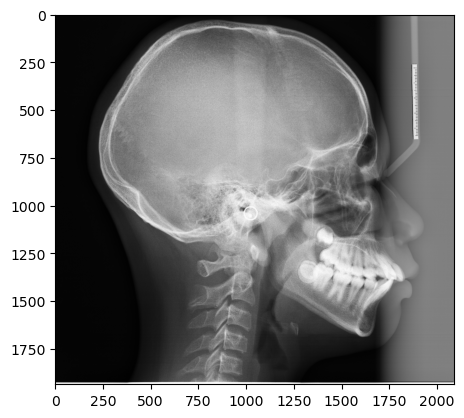

In [4]:
img = load_image("C:/Users/victo/Downloads/dental-cepha-dataset/dental-cepha-dataset/image/10.bmp")
plt.imshow(img, 'gray')

In [5]:
landmarks = load_landmarks("C:/Users/victo/Downloads/dental-cepha-dataset/dental-cepha-dataset/doctor1/10.txt")

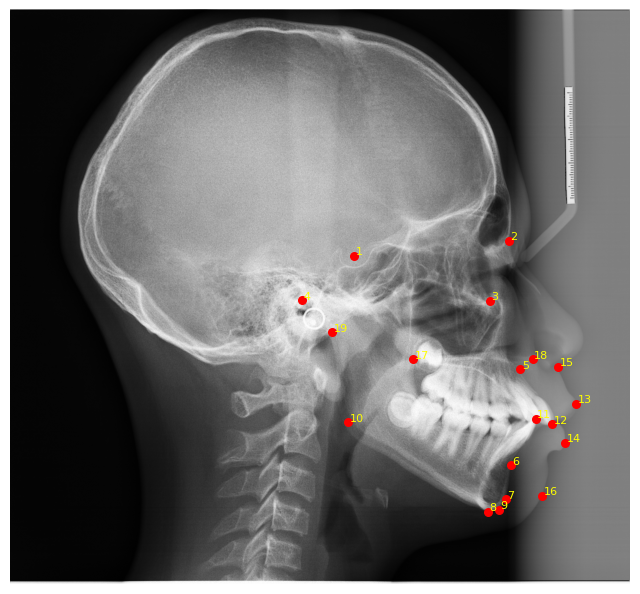

In [6]:
plot_landmarks(img, landmarks)

The landmarks are numbered in the same order they appear in the txt file. For measurements, they should be mapped to their proper names, for example: 1='Sella', 2='Nasion'

In [ ]:
lm_map = {
    'S': 1,
    'N': 2,
    'Or': 3,
    'Po': 4,
    'A': 5,
    'B': 6,
    'Pog': 7,
    'Me': 8,
    'Gn': 9,
    'Go': 10,
    'Lit': 11,
    'Uit': 12,
    'Ls': 13,
    'Li': 14,
    'Sn': 15,
    'Pos': 16,
    'PNS': 17,
    'ANS': 18,
    'AR': 19,
}

Please note, this mapping has been assembled by comparing the image above with references from the internet. More images should be verified to check whether the mapping is consistent.

In [8]:
def calculate_angle(center, point1, point2):
    """
    Calculate angle at 'center' between lines to point1 and point2.
    Returns angle in degrees.
    """
    vector1 = np.array([point1[0] - center[0], point1[1] - center[1]])
    vector2 = np.array([point2[0] - center[0], point2[1] - center[1]])
    
    cos_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_radians = np.arccos(cos_angle)
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

def calculate_angle_between_lines(point1, point2, point3, point4):
    """
    Calculate angle between two lines: (point1-point2) and (point3-point4).
    Returns angle in degrees.
    """
    v1 = np.array([point2[0] - point1[0], point2[1] - point1[1]])
    v2 = np.array([point4[0] - point3[0], point4[1] - point3[1]])
    
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_radians = np.arccos(cos_angle)
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

def calculate_distance(point1, point2):
    """
    Calculate Euclidean distance between two points.
    Returns distance in pixels.
    """
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

In [9]:
def classify_sna(angle):
    """Classify SNA angle (maxillary position)."""
    if 80 <= angle <= 84:
        return "Normal maxillary position"
    elif angle < 80:
        return "Retrognathic maxilla"
    else:
        return "Prognathic maxilla"

def classify_snb(angle):
    """Classify SNB angle (mandibular position)."""
    if 78 <= angle <= 82:
        return "Normal mandibular position"
    elif angle < 78:
        return "Retrognathic mandible"
    else:
        return "Prognathic mandible"

def classify_anb(angle):
    """Classify ANB angle (skeletal class)."""
    if 2 <= angle <= 4:
        return "Class I skeletal pattern"
    elif angle > 4:
        return "Class II skeletal pattern"
    else:
        return "Class III skeletal pattern"

def classify_mandibular_plane(angle):
    """Classify mandibular plane angle (vertical dimension)."""
    if 27 <= angle <= 37:
        return "Normal vertical dimension"
    elif angle < 27:
        return "Horizontal growth (brachyfacial)"
    else:
        return "Vertical growth (dolichofacial)"

def classify_mp_fh(angle):
    """Classify mandibular plane to FH angle."""
    if 21 <= angle <= 29:
        return "Normal mandibular inclination"
    elif angle < 21:
        return "Flat mandibular plane"
    else:
        return "Steep mandibular plane"

def classify_y_axis(angle):
    """Classify Y-axis angle (growth direction)."""
    if 63 <= angle <= 69:
        return "Normal growth axis"
    elif angle < 63:
        return "Horizontal growth tendency"
    else:
        return "Vertical growth tendency"

def classify_facial_angle(angle):
    """Classify facial angle (profile)."""
    if 87 <= angle <= 93:
        return "Normal facial profile"
    elif angle < 87:
        return "Retrognathic profile"
    else:
        return "Prognathic profile"

def classify_fh_ratio(ratio):
    """Classify facial height ratio."""
    if 62 <= ratio <= 65:
        return "Normal facial proportion"
    elif ratio < 62:
        return "Short posterior face height"
    else:
        return "Long posterior face height"

In [10]:
def comprehensive_cephalometric_analysis(landmarks, lm_map):
    """
    Perform comprehensive cephalometric analysis and return results in a DataFrame.
    
    Parameters:
    -----------
    landmarks : list
        List of (x, y) tuples representing landmark coordinates
    lm_map : dict
        Dictionary mapping landmark names to their indices (1-based)
    
    Returns:
    --------
    df : pandas DataFrame
        Analysis results with measurements, interpretations, and metadata
    points : dict
        Dictionary of landmark names to (x, y) coordinates
    """
    
    # Extract all landmark points
    points = {}
    for name, idx in lm_map.items():
        if idx <= len(landmarks):
            points[name] = landmarks[idx - 1]
    
    # Initialize results list
    results = []
    
    # ========================================
    # SKELETAL SAGITTAL MEASUREMENTS
    # ========================================
    
    # SNA Angle
    if all(k in points for k in ['S', 'N', 'A']):
        sna = calculate_angle(points['N'], points['S'], points['A'])
        results.append({
            'Category': 'Skeletal-Sagittal',
            'Measurement': 'SNA',
            'Value': sna,
            'Unit': '°',
            'Normal Range': '80-84',
            'Interpretation': classify_sna(sna),
            'Clinical Significance': 'Maxillary position relative to cranial base'
        })
    
    # SNB Angle
    if all(k in points for k in ['S', 'N', 'B']):
        snb = calculate_angle(points['N'], points['S'], points['B'])
        results.append({
            'Category': 'Skeletal-Sagittal',
            'Measurement': 'SNB',
            'Value': snb,
            'Unit': '°',
            'Normal Range': '78-82',
            'Interpretation': classify_snb(snb),
            'Clinical Significance': 'Mandibular position relative to cranial base'
        })
    
    # ANB Angle (calculated from difference)
    if 'sna' in locals() and 'snb' in locals():
        anb = sna - snb
        results.append({
            'Category': 'Skeletal-Sagittal',
            'Measurement': 'ANB',
            'Value': anb,
            'Unit': '°',
            'Normal Range': '2-4',
            'Interpretation': classify_anb(anb),
            'Clinical Significance': 'Jaw relationship (Angle Classification)'
        })
    
    # ========================================
    # SKELETAL VERTICAL MEASUREMENTS
    # ========================================
    
    # Mandibular Plane Angle (Go-Me to S-N)
    if all(k in points for k in ['Go', 'Me', 'S', 'N']):
        mp_sn = calculate_angle_between_lines(
            points['Go'], points['Me'], points['S'], points['N']
        )
        results.append({
            'Category': 'Skeletal-Vertical',
            'Measurement': 'MP-SN',
            'Value': mp_sn,
            'Unit': '°',
            'Normal Range': '27-37',
            'Interpretation': classify_mandibular_plane(mp_sn),
            'Clinical Significance': 'Vertical growth pattern'
        })
    
    # Mandibular Plane to Frankfort Horizontal
    if all(k in points for k in ['Go', 'Me', 'P', 'O']):
        mp_fh = calculate_angle_between_lines(
            points['Go'], points['Me'], points['P'], points['O']
        )
        results.append({
            'Category': 'Skeletal-Vertical',
            'Measurement': 'MP-FH',
            'Value': mp_fh,
            'Unit': '°',
            'Normal Range': '21-29',
            'Interpretation': classify_mp_fh(mp_fh),
            'Clinical Significance': 'Mandibular inclination'
        })
    
    # Y-Axis (S-Gn to S-N)
    if all(k in points for k in ['S', 'N', 'Gn']):
        y_axis = calculate_angle(points['S'], points['N'], points['Gn'])
        results.append({
            'Category': 'Skeletal-Vertical',
            'Measurement': 'Y-Axis',
            'Value': y_axis,
            'Unit': '°',
            'Normal Range': '63-69',
            'Interpretation': classify_y_axis(y_axis),
            'Clinical Significance': 'Growth direction'
        })
    
    # ========================================
    # PROFILE MEASUREMENTS
    # ========================================
    
    # Facial Angle (N-Pog to FH)
    if all(k in points for k in ['N', 'Pog', 'P', 'O']):
        facial_angle = calculate_angle_between_lines(
            points['N'], points['Pog'], points['P'], points['O']
        )
        results.append({
            'Category': 'Profile',
            'Measurement': 'Facial Angle',
            'Value': facial_angle,
            'Unit': '°',
            'Normal Range': '87-93',
            'Interpretation': classify_facial_angle(facial_angle),
            'Clinical Significance': 'Overall facial profile'
        })
    
    # ========================================
    # LINEAR MEASUREMENTS (in pixels)
    # ========================================
    
    # Anterior Facial Height (N-Me)
    if all(k in points for k in ['N', 'Me']):
        afh = calculate_distance(points['N'], points['Me'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'AFH (N-Me)',
            'Value': afh,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Total anterior face height',
            'Clinical Significance': 'Vertical dimension'
        })
    
    # Posterior Facial Height (S-Go)
    if all(k in points for k in ['S', 'Go']):
        pfh = calculate_distance(points['S'], points['Go'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'PFH (S-Go)',
            'Value': pfh,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Total posterior face height',
            'Clinical Significance': 'Vertical dimension'
        })
    
    # Facial Height Ratio (PFH/AFH)
    if 'afh' in locals() and 'pfh' in locals() and afh > 0:
        fh_ratio = (pfh / afh) * 100
        results.append({
            'Category': 'Ratio',
            'Measurement': 'PFH/AFH Ratio',
            'Value': fh_ratio,
            'Unit': '%',
            'Normal Range': '62-65',
            'Interpretation': classify_fh_ratio(fh_ratio),
            'Clinical Significance': 'Facial proportion'
        })
    
    # Maxillary Length (ANS-PNS)
    if all(k in points for k in ['ANS', 'PNS']):
        max_length = calculate_distance(points['ANS'], points['PNS'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'Maxillary Length',
            'Value': max_length,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Maxillary anteroposterior dimension',
            'Clinical Significance': 'Maxillary size'
        })
    
    # Mandibular Length (Go-Gn)
    if all(k in points for k in ['Go', 'Gn']):
        mand_length = calculate_distance(points['Go'], points['Gn'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'Mandibular Length',
            'Value': mand_length,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Mandibular body length',
            'Clinical Significance': 'Mandibular size'
        })
    
    # NA Distance
    if all(k in points for k in ['N', 'A']):
        na_dist = calculate_distance(points['N'], points['A'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'NA Distance',
            'Value': na_dist,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Nasion to A point distance',
            'Clinical Significance': 'Maxillary anteroposterior position'
        })
    
    # NB Distance
    if all(k in points for k in ['N', 'B']):
        nb_dist = calculate_distance(points['N'], points['B'])
        results.append({
            'Category': 'Linear',
            'Measurement': 'NB Distance',
            'Value': nb_dist,
            'Unit': 'pixels',
            'Normal Range': 'N/A (needs calibration)',
            'Interpretation': 'Nasion to B point distance',
            'Clinical Significance': 'Mandibular anteroposterior position'
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Add metadata
    df['Timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    return df, points

In [11]:
def plot_analysis_visualization(img, df, points):
    """
    Create a comprehensive visualization with all measurements.
    
    Parameters:
    -----------
    img : numpy array
        Grayscale cephalometric image
    df : pandas DataFrame
        Analysis results
    points : dict
        Dictionary of landmark coordinates
    
    Returns:
    --------
    fig : matplotlib Figure
        Complete visualization figure
    """
    
    fig = plt.figure(figsize=(16, 10))
    
    # ========================================
    # Main image with annotations
    # ========================================
    ax1 = plt.subplot(2, 3, (1, 4))
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Draw reference lines with specific colors
    line_configs = [
        (['S', 'N'], (255, 255, 0), 2),      # S-N in yellow
        (['N', 'A'], (255, 0, 0), 2),        # N-A in red
        (['N', 'B'], (0, 0, 255), 2),        # N-B in blue
        (['Go', 'Me'], (0, 255, 0), 2),      # Go-Me in green
        (['P', 'O'], (0, 255, 255), 2),      # P-O (FH) in cyan
        (['ANS', 'PNS'], (255, 128, 0), 2),  # ANS-PNS in orange
        (['Go', 'Gn'], (128, 0, 255), 2),    # Go-Gn in purple
    ]
    
    for point_names, color, thickness in line_configs:
        if all(name in points for name in point_names):
            cv2.line(img_color, points[point_names[0]], 
                    points[point_names[1]], color, thickness)
    
    # Draw all landmark points
    for name, point in points.items():
        cv2.circle(img_color, point, 4, (255, 255, 255), -1)
        cv2.putText(img_color, name, (point[0]+5, point[1]-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    ax1.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    ax1.set_title('Cephalometric Analysis', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # ========================================
    # Angular measurements bar chart
    # ========================================
    ax2 = plt.subplot(2, 3, 2)
    angular_df = df[df['Unit'] == '°'].copy()
    
    # Color bars based on whether values are normal
    colors_bar = []
    for _, row in angular_df.iterrows():
        if 'Normal' in row['Interpretation']:
            colors_bar.append('green')
        elif 'Class I' in row['Interpretation']:
            colors_bar.append('green')
        else:
            colors_bar.append('orange')
    
    bars = ax2.barh(angular_df['Measurement'], angular_df['Value'], color=colors_bar)
    ax2.set_xlabel('Degrees (°)')
    ax2.set_title('Angular Measurements', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, angular_df['Value']):
        ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f'{value:.1f}°', va='center')
    
    # ========================================
    # Category distribution pie chart
    # ========================================
    ax3 = plt.subplot(2, 3, 3)
    category_counts = df['Category'].value_counts()
    colors_pie = plt.cm.Set3(range(len(category_counts)))
    ax3.pie(category_counts.values, labels=category_counts.index, 
            autopct='%1.0f%%', colors=colors_pie)
    ax3.set_title('Measurement Categories', fontweight='bold')
    
    # ========================================
    # Summary table
    # ========================================
    ax4 = plt.subplot(2, 3, 5)
    ax4.axis('tight')
    ax4.axis('off')
    
    # Select key measurements for table
    key_measurements = ['SNA', 'SNB', 'ANB', 'MP-SN', 'Facial Angle', 'Y-Axis']
    table_df = df[df['Measurement'].isin(key_measurements)][
        ['Measurement', 'Value', 'Normal Range', 'Interpretation']
    ].copy()
    
    if not table_df.empty:
        table_df['Value'] = table_df['Value'].apply(lambda x: f'{x:.1f}')
        
        table = ax4.table(cellText=table_df.values,
                         colLabels=table_df.columns,
                         cellLoc='left',
                         loc='center',
                         colColours=['lightgray']*4)
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
    
    ax4.set_title('Key Measurements Summary', fontweight='bold', pad=20)
    
    # ========================================
    # Clinical interpretation summary
    # ========================================
    ax5 = plt.subplot(2, 3, 6)
    ax5.axis('off')
    
    summary_text = "DIAGNOSTIC SUMMARY\n" + "="*25 + "\n\n"
    
    # Add key findings
    anb_row = df[df['Measurement'] == 'ANB']
    if not anb_row.empty:
        interp = anb_row['Interpretation'].values[0]
        skeletal_class = interp.split()[0] + ' ' + interp.split()[1]
        summary_text += f"• Skeletal Pattern: {skeletal_class}\n"
    
    mp_row = df[df['Measurement'] == 'MP-SN']
    if not mp_row.empty:
        growth = mp_row['Interpretation'].values[0].split('(')[0].strip()
        summary_text += f"• Growth Pattern: {growth}\n"
    
    sna_row = df[df['Measurement'] == 'SNA']
    if not sna_row.empty:
        maxilla = sna_row['Interpretation'].values[0].split()[0]
        summary_text += f"• Maxilla: {maxilla}\n"
    
    snb_row = df[df['Measurement'] == 'SNB']
    if not snb_row.empty:
        mandible = snb_row['Interpretation'].values[0].split()[0]
        summary_text += f"• Mandible: {mandible}\n"
    
    facial_row = df[df['Measurement'] == 'Facial Angle']
    if not facial_row.empty:
        profile = facial_row['Interpretation'].values[0].split()[0]
        summary_text += f"• Profile: {profile}\n"
    
    ax5.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
            fontfamily='monospace', bbox=dict(boxstyle='round', 
            facecolor='lightgray', alpha=0.5))
    ax5.set_title('Clinical Interpretation', fontweight='bold')
    
    plt.suptitle('Comprehensive Cephalometric Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    return fig

In [12]:
def generate_summary_report(df):
    """
    Generate a text summary report from the analysis DataFrame.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Analysis results
    """
    
    print("\n" + "="*60)
    print("CEPHALOMETRIC ANALYSIS REPORT")
    print("="*60)
    print(f"Analysis Date: {df['Timestamp'].iloc[0] if not df.empty else 'N/A'}")
    print("="*60)
    
    # Print by category
    for category in df['Category'].unique():
        print(f"\n{category.upper()} MEASUREMENTS:")
        print("-"*40)
        
        category_df = df[df['Category'] == category]
        for _, row in category_df.iterrows():
            print(f"\n{row['Measurement']}:")
            print(f"  Value: {row['Value']:.2f} {row['Unit']}")
            print(f"  Normal Range: {row['Normal Range']} {row['Unit']}")
            print(f"  Interpretation: {row['Interpretation']}")
    
    # Overall assessment
    print("\n" + "="*60)
    print("OVERALL SKELETAL PATTERN ASSESSMENT:")
    print("="*60)
    
    # Check for skeletal class
    anb_row = df[df['Measurement'] == 'ANB']
    if not anb_row.empty:
        print(f"Skeletal Classification: {anb_row['Interpretation'].values[0]}")
    
    # Check for vertical pattern
    mp_row = df[df['Measurement'] == 'MP-SN']
    if not mp_row.empty:
        print(f"Vertical Pattern: {mp_row['Interpretation'].values[0]}")
    
    # Check for profile
    facial_row = df[df['Measurement'] == 'Facial Angle']
    if not facial_row.empty:
        print(f"Facial Profile: {facial_row['Interpretation'].values[0]}")
    
    print("\n" + "="*60)

In [13]:
def run_complete_analysis(img, landmarks, lm_map, 
                         save_csv=False, csv_filename='ceph_analysis.csv',
                         show_plots=True):
    """
    Run complete cephalometric analysis and optionally save results.
    
    Parameters:
    -----------
    img : numpy array
        Grayscale cephalometric image
    landmarks : list
        List of (x, y) landmark coordinates
    lm_map : dict
        Dictionary mapping landmark names to indices
    save_csv : bool
        Whether to save results to CSV
    csv_filename : str
        Filename for CSV output
    show_plots : bool
        Whether to display plots
    
    Returns:
    --------
    df : pandas DataFrame
        Complete analysis results
    fig : matplotlib Figure or None
        Visualization figure (None if show_plots=False)
    """
    
    # Perform analysis
    df, points = comprehensive_cephalometric_analysis(landmarks, lm_map)
    
    # Generate summary report
    generate_summary_report(df)
    
    # Create visualization if requested
    fig = None
    if show_plots:
        fig = plot_analysis_visualization(img, df, points)
        plt.show()
    
    # Save to CSV if requested
    if save_csv:
        df.to_csv(csv_filename, index=False)
        print(f"\nAnalysis saved to {csv_filename}")
    
    # Display DataFrame
    print("\n" + "="*60)
    print("DETAILED MEASUREMENTS DATAFRAME:")
    print("="*60)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    print(df.to_string(index=False))
    
    return df, fig


CEPHALOMETRIC ANALYSIS REPORT
Analysis Date: 2025-09-24 09:05:47

SKELETAL-SAGITTAL MEASUREMENTS:
----------------------------------------

SNA:
  Value: 89.56 °
  Normal Range: 80-84 °
  Interpretation: Prognathic maxilla

SNB:
  Value: 84.86 °
  Normal Range: 78-82 °
  Interpretation: Prognathic mandible

ANB:
  Value: 4.69 °
  Normal Range: 2-4 °
  Interpretation: Class II skeletal pattern

SKELETAL-VERTICAL MEASUREMENTS:
----------------------------------------

MP-SN:
  Value: 38.34 °
  Normal Range: 27-37 °
  Interpretation: Vertical growth (dolichofacial)

MP-FH:
  Value: 32.66 °
  Normal Range: 21-29 °
  Interpretation: Steep mandibular plane

Y-Axis:
  Value: 65.90 °
  Normal Range: 63-69 °
  Interpretation: Normal growth axis

PROFILE MEASUREMENTS:
----------------------------------------

Facial Angle:
  Value: 90.57 °
  Normal Range: 87-93 °
  Interpretation: Normal facial profile

LINEAR MEASUREMENTS:
----------------------------------------

AFH (N-Me):
  Value: 916.75 p

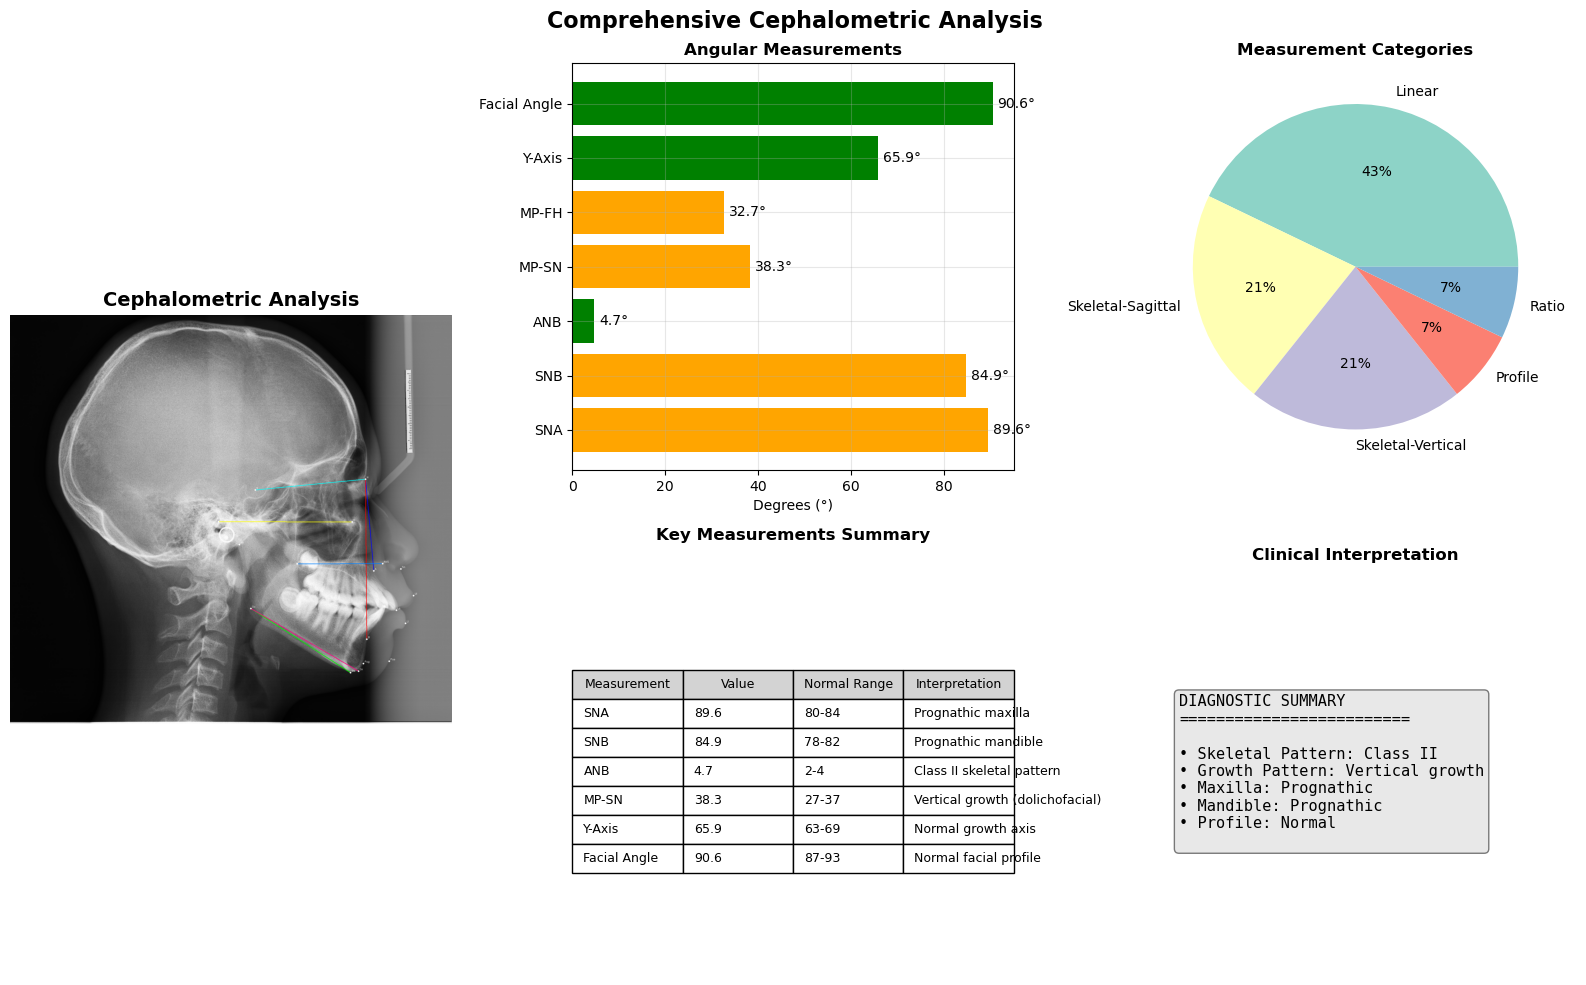


Analysis saved to patient_001_analysis.csv

DETAILED MEASUREMENTS DATAFRAME:
         Category       Measurement      Value   Unit            Normal Range                      Interpretation                        Clinical Significance           Timestamp
Skeletal-Sagittal               SNA  89.555906      °                   80-84                  Prognathic maxilla  Maxillary position relative to cranial base 2025-09-24 09:05:47
Skeletal-Sagittal               SNB  84.863923      °                   78-82                 Prognathic mandible Mandibular position relative to cranial base 2025-09-24 09:05:47
Skeletal-Sagittal               ANB   4.691983      °                     2-4           Class II skeletal pattern      Jaw relationship (Angle Classification) 2025-09-24 09:05:47
Skeletal-Vertical             MP-SN  38.344463      °                   27-37     Vertical growth (dolichofacial)                      Vertical growth pattern 2025-09-24 09:05:47
Skeletal-Vertical          

In [14]:
df, fig = run_complete_analysis(img, landmarks, lm_map, 
                                save_csv=True,
                                csv_filename='patient_001_analysis.csv',
                                show_plots=True)

We've established the feasibility of calculating standard angles. We'll need to ask the client which standard measurements (Steiner, Ricketts, Downs etc.) are most useful for dentists, as there are more than 100 when combining both angular and linear.

In [2]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path

# Define paths
image_dir = r"C:\Users\victo\Downloads\Aariz\Aariz\train\Cephalograms"
annotation_dir = r"C:\Users\victo\Downloads\Aariz\Aariz\train\Annotations\Cephalometric Landmarks\Senior Orthodontists"

# Define the 19 landmarks we need (based on your requirements)
required_landmarks = [
    "A-point", "Anterior Nasal Spine", "B-point", "Menton", "Nasion",
    "Orbitale", "Pogonion", "Posterior Nasal Spine", "Sella", "Articulare",
    "Gnathion", "Gonion", "Porion", "Lower Incisor Tip", "Upper Incisor Tip",
    "Labrale inferius", "Labrale superius", "Soft Tissue Pogonion", "Subnasale"
]

# Color map for different landmark types
landmark_colors = {
    # Skeletal landmarks
    "A-point": '#FF0000', "B-point": '#FF4500', "Menton": '#FF6347',
    "Nasion": '#00FF00', "Sella": '#32CD32', "Articulare": '#228B22',
    "Gnathion": '#0000FF', "Gonion": '#4169E1', "Porion": '#1E90FF',
    "Orbitale": '#FF1493', "Pogonion": '#FF69B4',
    # Nasal spine landmarks
    "Anterior Nasal Spine": '#FFD700', "Posterior Nasal Spine": '#FFA500',
    # Dental landmarks
    "Lower Incisor Tip": '#9370DB', "Upper Incisor Tip": '#8A2BE2',
    # Soft tissue landmarks
    "Labrale inferius": '#00CED1', "Labrale superius": '#20B2AA',
    "Soft Tissue Pogonion": '#48D1CC', "Subnasale": '#40E0D0'
}

def load_image(image_path):
    """Load an image from various formats"""
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_annotation(json_path):
    """Load annotation from JSON file"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading annotation {json_path}: {e}")
        return None

def get_ceph_id_from_filename(filename):
    """Extract ceph_id from filename"""
    # Remove extension and return the base name
    return Path(filename).stem

def plot_landmarks_on_images(num_images=5):
    """Main function to plot landmarks on random images"""
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']:
        image_files.extend(Path(image_dir).glob(ext))
        image_files.extend(Path(image_dir).glob(ext.upper()))
    
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    # Get all annotation files
    annotation_files = list(Path(annotation_dir).glob('*.json'))
    if not annotation_files:
        print(f"No annotation files found in {annotation_dir}")
        return
    
    # Create a mapping of ceph_id to annotation file
    annotation_map = {}
    for ann_file in annotation_files:
        ann_data = load_annotation(ann_file)
        if ann_data and 'ceph_id' in ann_data:
            annotation_map[ann_data['ceph_id']] = ann_file
    
    # Try to match images with annotations
    matched_pairs = []
    for img_file in image_files:
        ceph_id = get_ceph_id_from_filename(img_file.name)
        if ceph_id in annotation_map:
            matched_pairs.append((img_file, annotation_map[ceph_id]))
    
    if not matched_pairs:
        print("No matching image-annotation pairs found")
        print(f"Sample image names: {[f.name for f in image_files[:5]]}")
        print(f"Sample ceph_ids from annotations: {list(annotation_map.keys())[:5]}")
        return
    
    # Select random images
    selected_pairs = random.sample(matched_pairs, min(num_images, len(matched_pairs)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(selected_pairs), figsize=(20, 8))
    if len(selected_pairs) == 1:
        axes = [axes]
    
    for idx, (img_path, ann_path) in enumerate(selected_pairs):
        # Load image
        img = load_image(img_path)
        if img is None:
            continue
        
        # Load annotation
        ann_data = load_annotation(ann_path)
        if ann_data is None:
            continue
        
        # Display image
        axes[idx].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[idx].set_title(f"Image {idx+1}\n{img_path.name[:20]}...", fontsize=10)
        axes[idx].axis('off')
        
        # Plot landmarks
        landmarks_plotted = []
        landmarks_missing = []
        
        for landmark in ann_data.get('landmarks', []):
            landmark_title = landmark.get('title', '')
            if landmark_title in required_landmarks:
                x = landmark['value']['x']
                y = landmark['value']['y']
                symbol = landmark.get('symbol', '')
                color = landmark_colors.get(landmark_title, '#FFFFFF')
                
                # Plot point
                axes[idx].plot(x, y, 'o', color=color, markersize=6, markeredgewidth=1, 
                             markeredgecolor='white', alpha=0.8)
                
                # Add label
                axes[idx].text(x+5, y-5, symbol, fontsize=8, color=color, 
                             fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                             facecolor='white', alpha=0.7, edgecolor='none'))
                
                landmarks_plotted.append(landmark_title)
        
        # Check for missing landmarks
        for req_landmark in required_landmarks:
            if req_landmark not in landmarks_plotted:
                # Special case for "Soft Tissue Pogonion" which might be labeled as "Pog`"
                found = False
                for landmark in ann_data.get('landmarks', []):
                    if (req_landmark == "Soft Tissue Pogonion" and 
                        landmark.get('symbol') == "Pog`"):
                        x = landmark['value']['x']
                        y = landmark['value']['y']
                        color = landmark_colors.get(req_landmark, '#FFFFFF')
                        axes[idx].plot(x, y, 'o', color=color, markersize=6, 
                                     markeredgewidth=1, markeredgecolor='white', alpha=0.8)
                        axes[idx].text(x+5, y-5, "Pog`", fontsize=8, color=color, 
                                     fontweight='bold', bbox=dict(boxstyle='round,pad=0.2', 
                                     facecolor='white', alpha=0.7, edgecolor='none'))
                        found = True
                        break
                if not found:
                    landmarks_missing.append(req_landmark)
        
        # Print statistics
        print(f"\nImage {idx+1}: {img_path.name}")
        print(f"  Landmarks plotted: {len(landmarks_plotted)}/19")
        if landmarks_missing:
            print(f"  Missing landmarks: {', '.join(landmarks_missing[:5])}")
            if len(landmarks_missing) > 5:
                print(f"    ... and {len(landmarks_missing)-5} more")
    
    # Add legend
    handles = []
    labels = []
    for landmark, color in list(landmark_colors.items())[:10]:  # Show first 10 in legend
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color, markersize=8))
        labels.append(landmark)
    
    fig.legend(handles, labels, loc='lower center', ncol=5, 
              bbox_to_anchor=(0.5, -0.1), fontsize=8)
    
    plt.suptitle('Cephalometric Landmark Detection - 19 Key Points', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [4]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path

# Define paths
image_dir = r"C:\Users\victo\Downloads\Aariz\Aariz\train\Cephalograms"
annotation_dir = r"C:\Users\victo\Downloads\Aariz\Aariz\train\Annotations\Cephalometric Landmarks\Senior Orthodontists"
output_dir = r"C:\Users\victo\Downloads\Aariz\Aariz\landmark_overlays"  # Output directory

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the 19 landmarks we need
required_landmarks = [
    "A-point", "Anterior Nasal Spine", "B-point", "Menton", "Nasion",
    "Orbitale", "Pogonion", "Posterior Nasal Spine", "Sella", "Articulare",
    "Gnathion", "Gonion", "Porion", "Lower Incisor Tip", "Upper Incisor Tip",
    "Labrale inferius", "Labrale superius", "Soft Tissue Pogonion", "Subnasale"
]

def load_image(image_path):
    """Load an image from various formats"""
    try:
        img = Image.open(image_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def load_annotation(json_path):
    """Load annotation from JSON file"""
    try:
        with open(json_path, 'r') as f:
            return json.load(f)
    except Exception as e:
        print(f"Error loading annotation {json_path}: {e}")
        return None

def get_ceph_id_from_filename(filename):
    """Extract ceph_id from filename"""
    return Path(filename).stem

def plot_and_save_single_image(img_path, ann_path, output_path):
    """Plot landmarks on a single image and save it"""
    
    # Load image
    img = load_image(img_path)
    if img is None:
        return False
    
    # Load annotation
    ann_data = load_annotation(ann_path)
    if ann_data is None:
        return False
    
    # Create figure with proper size
    height, width = img.shape[:2]
    fig_width = 10
    fig_height = fig_width * (height / width)
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Display image
    ax.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    ax.axis('off')
    
    # Plot landmarks
    landmarks_found = 0
    
    for landmark in ann_data.get('landmarks', []):
        landmark_title = landmark.get('title', '')
        
        # Check if this is one of our required landmarks
        if landmark_title in required_landmarks:
            x = landmark['value']['x']
            y = landmark['value']['y']
            symbol = landmark.get('symbol', '')
            
            # Plot red dot
            ax.plot(x, y, 'o', color='red', markersize=4, markeredgewidth=0.5, 
                   markeredgecolor='darkred')
            
            # Add small red text label
            ax.text(x+3, y-3, symbol, fontsize=6, color='red', 
                   fontweight='normal')
            
            landmarks_found += 1
        
        # Special case for "Soft Tissue Pogonion" which might be "Pog`"
        elif landmark.get('symbol') == "Pog`" and "Soft Tissue Pogonion" in required_landmarks:
            x = landmark['value']['x']
            y = landmark['value']['y']
            
            ax.plot(x, y, 'o', color='red', markersize=4, markeredgewidth=0.5, 
                   markeredgecolor='darkred')
            ax.text(x+3, y-3, "Pog`", fontsize=6, color='red', 
                   fontweight='normal')
            
            landmarks_found += 1
    
    # Remove all margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    # Save figure
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.close()
    
    return landmarks_found

def process_random_images(num_images=5):
    """Process random images and save them with landmark overlays"""
    
    print("Loading images and annotations...")
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.tif']:
        image_files.extend(Path(image_dir).glob(ext))
        image_files.extend(Path(image_dir).glob(ext.upper()))
    
    if not image_files:
        print(f"No images found in {image_dir}")
        return
    
    print(f"Found {len(image_files)} images")
    
    # Get all annotation files
    annotation_files = list(Path(annotation_dir).glob('*.json'))
    print(f"Found {len(annotation_files)} annotation files")
    
    # Create mapping of ceph_id to annotation file
    annotation_map = {}
    for ann_file in annotation_files:
        ann_data = load_annotation(ann_file)
        if ann_data and 'ceph_id' in ann_data:
            annotation_map[ann_data['ceph_id']] = ann_file
    
    # Match images with annotations
    matched_pairs = []
    for img_file in image_files:
        ceph_id = get_ceph_id_from_filename(img_file.name)
        if ceph_id in annotation_map:
            matched_pairs.append((img_file, annotation_map[ceph_id]))
    
    print(f"Found {len(matched_pairs)} matching image-annotation pairs")
    
    if not matched_pairs:
        print("No matching pairs found!")
        return
    
    # Select random images
    selected_pairs = random.sample(matched_pairs, min(num_images, len(matched_pairs)))
    
    print(f"\nProcessing {len(selected_pairs)} random images...")
    print("="*50)
    
    # Process each image
    for idx, (img_path, ann_path) in enumerate(selected_pairs, 1):
        # Create output filename
        output_filename = f"landmarks_{img_path.stem}.png"
        output_path = Path(output_dir) / output_filename
        
        print(f"\nImage {idx}/{len(selected_pairs)}: {img_path.name}")
        
        # Process and save
        landmarks_count = plot_and_save_single_image(img_path, ann_path, output_path)
        
        if landmarks_count:
            print(f"  ✓ Plotted {landmarks_count}/19 landmarks")
            print(f"  ✓ Saved to: {output_path}")
        else:
            print(f"  ✗ Failed to process")
    
    print("\n" + "="*50)
    print(f"Processing complete! Check output folder: {output_dir}")

In [5]:
if __name__ == "__main__":
    # Process 5 random images
    process_random_images(num_images=5)

Loading images and annotations...
Found 1400 images
Found 700 annotation files
Found 1400 matching image-annotation pairs

Processing 5 random images...

Image 1/5: cl6cc2n5i401f0771as4t0pmi.jpeg
  ✓ Plotted 19/19 landmarks
  ✓ Saved to: C:\Users\victo\Downloads\Aariz\Aariz\landmark_overlays\landmarks_cl6cc2n5i401f0771as4t0pmi.png

Image 2/5: cl5lg05ur01lu074kexxr1ofb.jpg
  ✓ Plotted 19/19 landmarks
  ✓ Saved to: C:\Users\victo\Downloads\Aariz\Aariz\landmark_overlays\landmarks_cl5lg05ur01lu074kexxr1ofb.png

Image 3/5: cl5lg05ue018y074kdq6yc9cj.jpg
  ✓ Plotted 19/19 landmarks
  ✓ Saved to: C:\Users\victo\Downloads\Aariz\Aariz\landmark_overlays\landmarks_cl5lg05ue018y074kdq6yc9cj.png

Image 4/5: cl7wxu5n5agfg077naial22ae.bmp
  ✓ Plotted 19/19 landmarks
  ✓ Saved to: C:\Users\victo\Downloads\Aariz\Aariz\landmark_overlays\landmarks_cl7wxu5n5agfg077naial22ae.png

Image 5/5: cks2ip8g62b6r0yuf65bga4sa.png
  ✓ Plotted 19/19 landmarks
  ✓ Saved to: C:\Users\victo\Downloads\Aariz\Aariz\landmark_